# Let's build Hartree-Fock part 3: Roothan-Hall equations

This tutorial covers topics from section 3.4 from the *Modern Quantum Chemistry* by Szabo and Ostlund. The equations are numbered to correspond to the numbering in the book.

### The Roothan-Hall equations

<!--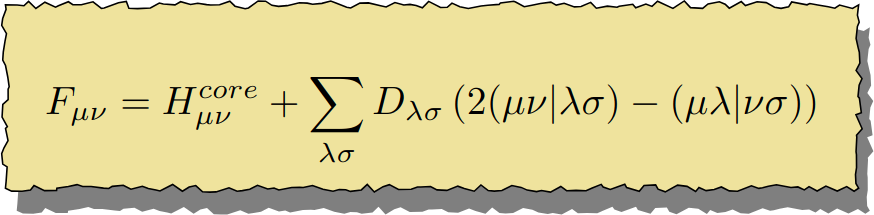 -->

When we expand the orbitals in the Hartree-Fock equations as a linear combination of atomic orbitals (LCAO), we end up with the Roothan-Hall equations (eqn. 3.139):

$$\mathbf{F}\mathbf{C} = \mathbf{S}\mathbf{C}\mathbf{\epsilon},$$

where 
* $\mathbf{C}$ is the matrix of molecular orbital coefficients. Each column corresponds to a molecular orbital, expressed as a linear combination of the basis set functions
* $\mathbf{S}$ is the overlap matrix, each element $S_{\mu\nu}$ contains the overlap integrals between the basis functions $\mu$ and $\nu$
* $\mathbf{\epsilon}$ is a diagonal matrix of orbital energies, each element corresponding to the energy of a molecular orbital
* $\mathbf{F}$ is the so-called Fock matrix (eqn. 3.154),

$$F_{\mu\nu} = H_{\mu\nu}^{\text{core}} + \sum_{\lambda\sigma}D_{\lambda\sigma}\left( 2(\mu\nu|\lambda\sigma) - (\mu\lambda|\nu\sigma) \right),$$

where $\mathbf{D}$ is the so-called density matrix, describing the population of each orbital in the system.

The Roothan-Hall equations are for the so-called **restricted Hartree-Fock** system, i.e. we assume an even number of electrons and that all occupied orbitals are populated with a spin up and a spin down electron. The core Hamiltonian consists of the one-electron components, i.e. the kinetic and electron-nucleus interaction terms. The latter term is the two-electron component, consisting of the Coulomb and exchange interaction between the electrons. In order to diagonalize (solve) the Fock matrix, we need to use an orthogonalization scheme discussed in the previous entry. The orthogonalization matrix transforms us from the atomic orbital (AO) basis into the molecular orbital (MO) basis. 

However, we cannot solve the Fock matrix directly, since in order to compute the two-electron part of the Fock matrix, we would need to have the orbitals at hand already. Therefore, we need to first get an initial guess of the molecular orbitals. We will then solve the Fock matrix using these guess orbitals and compare whether our new solution matches the guess orbitals. We will then run this solve cycle iteratively until (hopefully) reaching a convergence. This is called **the self consistent cycle (SCF)**.

### Molecular integrals and orthogonalization

Let's have a look at what the different matrices in our Roothan-Hall equation contain. In the LCAO method, a set of atom-centered basis functions are placed on top the atomic nuclei and all the necessary integrals between the different basis functions are computed. This is done well in advance of the SCF. In the different matrices we have
- Overlap (eqn. 3.136)

$$S_{ij} = \int \phi_{i}(\mathbf{r}) \phi_{j}(\mathbf{r}) , d\mathbf{r}$$

- Kinetic energy (eqn. 3.151)

$$T_{ij} = \int \phi_{i}(\mathbf{r}) \left( -\frac{1}{2} \nabla^2 \right) \phi_{j}(\mathbf{r}) , d\mathbf{r}$$

- Nuclear attraction (eqn. 3.152)

$$V_{ij} = \int \phi_{i}(\mathbf{r}) \left( - \sum_A \frac{Z_A}{|\mathbf{r} - \mathbf{R}A|} \right) \phi_{j}(\mathbf{r}) , d\mathbf{r}$$

- Electron-electron (eqn. 3.155)

$$V_{ijkl} = (ij|kl) = \int \frac{\phi_{i}(\mathbf{r}_1) \phi{j}(\mathbf{r}_1) \phi{k}(\mathbf{r}_2) \phi_{l}(\mathbf{r}_2)}{|\mathbf{r}_1 - \mathbf{r}_2|} d\mathbf{r}_1 d\mathbf{r}_2$$

The core Hamiltonian is the sum of the kinetic and electron-nucleus interaction terms, $H_{\mu\nu}^{\text{core}} = T_{\mu\nu} + V_{\mu\nu}$. 

Here, we will have a look at how to construct an initial guess for our molecular orbitals. Implementing these integrals can be very cumbersome, especially for orbitals with angular momentum and instead of implemeting them ourselves, we''ll use the PySCF quantum chemistry package to gain all the necessary matrices.

Let's begin by constructing a PySCF molecule object. We will then extract the molecular integrals for this system using the *intor*-function.

In [50]:
from pyscf import gto, scf, mp
from ase.units import Bohr
import numpy as np

m = gto.Mole()
m.build(atom=f"H 0 0 0; H {1.4*Bohr} 0 0", basis="3-21g", spin=0, charge=0)
Tmat = m.intor("int1e_kin") # Integral matrix for kinetic energy, eqn 3.151
Smat = m.intor("int1e_ovlp") # Integral matrix for overlap integrals. eqn 3.136
Vmat = m.intor("int1e_nuc") # Integral matrix for electron-nuclei integrals, eqn 3.152
Vee = m.intor("int2e") # Integral matrix for electron-electron integrals, eqn 3.155
nelec = m.nelectron # Number of electrons
print(Tmat.shape, Smat.shape, Vmat.shape, Vee.shape)

(4, 4) (4, 4) (4, 4) (4, 4, 4, 4)


The first three matrices are $N\times N$ matrices, while the $\mathbf{V}_{ee}$ is a $N\times N\times N\times N$ array. The $N$ is the number of basis functions in our system and depends on the basis set we use and what kind of/how many atoms thereare in our system.

We will first use the symmetric orthogonalization method to construct a transformation matrix $\mathbf{X}$ that allows us to switch from the AO basis to the MO basis.

In [51]:
# Symmetric orthogonalization
s, U = np.linalg.eigh(Smat)
X = U / s**0.5 # Eqn 3.169

Next, we'll construct the Fock matrix from these components. The one-electron part is simple: we'll just add the kinetic and nucleus parts together. We'll then use the core Hamiltonian as an initial guess for the molecular orbitals, i.e. assuming that there is no interaction between the electrons. This is quite a crude approximation, but will work on our relatively simple system. Diagonalization will result in MO eigenvalues (energies) and vectors.

In [55]:
Hcore_AO = Tmat + Vmat
Hcore_MO = np.dot(X.T, Hcore_AO.dot(X)) # Transform from AO to MO basis
mo_eigs, mo_vecs = np.linalg.eigh(Hcore_MO) # Diagonalize the Hcore in MO basis

In order to construct the two-electron part of the Fock matrix, we need a density matrix that contains information on how the electron population is distributed among the AOs.
For this, we'lll use the molecular orbitals we obtained from the core Hamiltonian initial guess to construct a density matrix, $\mathbf{D} = \mathbf{C}^\dagger \mathbf{C}$. First, we'll transform the eigenvectors (i.e. MO coefficients) back to AO basis, where we have all our AO integrals. We will only consider the occupied molecular orbitals in our density matrix. The eigenvalues we obtain from the Numpy *eigh*-function are already ordered from the lowest eigenvalue to the highest, so we will just iterate over the first $\frac{N_\text{elec}}{2}$ states (this is the **aufbau**-principle).

In [56]:
Cvec = np.dot(X, mo_vecs) # Transform the MO coefficients from MO to AO basis
Dmat = np.zeros((Smat.shape)) # Initialize the density matrix
for a in range(nelec//2): # Compute the density matrix in the AO basis. Since we use restricted HF, all spins are paired and only nelec/2 orbitals are considered
    Dmat += np.einsum('i,j->ij', Cvec[:, a], Cvec[:, a].T) # Eqn 3.145

The Numpy function *einsum* is especially useful and powerful tool here. The density matrix is defined as (eqn 3.145, modified),

$$D_{ij} = \sum\limits_{a}^{N_\text{elec}/2} C_{i a} C_{j a}^*$$

This is what our einsum calculates.

The full Fock matrix is 

$$F_{\mu\nu} = H_{\mu\nu}^{\text{core}} + \sum_{\lambda\sigma}D_{\lambda\sigma}\left( 2(\mu\nu|\lambda\sigma) - (\mu\lambda|\nu\sigma) \right)$$

where the latter part is the two-electron component. This can be rewritten as

$$\sum_{\lambda\sigma}D_{\lambda\sigma}\left(2(\mu\nu|\lambda\sigma) - (\mu\lambda|\nu\sigma) \right) = 2{J}_{\mu\nu} - {K}_{\mu\nu}.$$

where $\mathbf{J}$ (eqn 2.182) and $\mathbf{K}$ (eqn 2.184) are called the Coulomb and Exchange parts, respectively:

$${J}_{\mu\nu} = D_{\lambda\sigma} \sum\limits_{\lambda\sigma} (\mu\nu|\lambda\sigma)$$

$${K}_{\mu\nu} = D_{\lambda\sigma} \sum\limits_{\lambda\sigma} (\mu\lambda|\nu\sigma)$$

with each integral corresponding to an element in the $\mathbf{V}_{ee}$ matrix,

$$V_{\mu\nu\lambda\sigma} = (\mu\nu|\lambda\sigma) = \int \int \phi_\mu(\mathbf{r}_1) \phi_\nu(\mathbf{r}_1) \frac{1}{r_{12}} \phi_\lambda(\mathbf{r}_2) \phi_\sigma(\mathbf{r}_2) \, d\mathbf{r}_1 d\mathbf{r}_2.$$

We can again use the *einsum*-function here to construct these matrices.

In [57]:
Jmat = np.einsum('kl, ijkl->ij', Dmat, Vee, optimize=True) # Compute the Coulomb integrals
Kmat = np.einsum('kl, ikjl->ij', Dmat, Vee, optimize=True) # Compute the exchange integrals

Now we have everything we need to run the SCF cycle! However, we still need to have a look at how we exactly compute the total electronic energy of the system: as it turns out, the total electronic energy of the Hartree-Fock system is **not** the sum of the eigenvalues of the occupied MOs.